This code is used to reproduce the experiments ran on the Go Out To Vote (GOTV) dataset. We used the EconML for the implementation of metalearners from Microsoft.

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/TTML Final Project

/content/drive/.shortcut-targets-by-id/1H5Ax63mdntm9bISC1wKbAJiQG5lq4BxA/TTML Final Project


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df.iloc[:,1:-1]

,sex,g2000,g2002,p2000,p2002,p2004,age,treatment
0,1,1,1,0,1,0,65,1
1,0,1,1,0,1,0,59,1
2,1,0,0,0,0,0,25,0
3,0,1,1,0,1,0,47,0
4,1,1,1,0,1,0,50,0
...,...,...,...,...,...,...,...,...
229456,1,1,1,0,1,1,63,0
229457,1,1,1,1,0,1,51,0
229458,0,1,0,0,0,0,48,0
229459,1,1,1,1,1,1,69,0


# GOTV EconML

In [ ]:
df = pd.read_csv("gotv.csv", header=0, names=["ID", 'sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age', 'treatment', 'voted'])

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(7)
trainset, testset = train_test_split(df, test_size=0.2, stratify=df['treatment'])

In [ ]:
full_X = df.iloc[:, 1:-2]
full_tr = df['treatment']
full_Y =  df['voted']

train_X = trainset.iloc[:,1:-2]
train_tr = trainset['treatment']
train_Y =  trainset['voted']

test_X = testset.iloc[:,1:-2]
test_tr = testset['treatment']
test_Y = testset['voted']

In [ ]:
# set up ground truth
models = RandomForestRegressor()
T_learner_truth = TLearner(models=models)
# Train T_learner
T_learner_truth.fit(X=full_X, T=full_tr, Y=full_Y)
# Estimate treatment effects on test data
T_te_ground_truth = T_learner_truth.effect(test_X)

In [ ]:
s_bias = []
t_bias = []
x_bias = []
s_var = []
t_var = []
x_var = []
s_mse = []
t_mse = []
x_mse = []
S_te_list = []
X_te_list = []
T_te_list = []

sample_size = np.array([1000,2000,3000,4000,5000,8000,15000,22000,35000,50000,60000, 70000])

for s in tqdm(sample_size):
    train_data, test_data = train_test_split(df, train_size=s, test_size=df.shape[0]-s, stratify=df['treatment'])
    train_X = train_data.iloc[:,1:-2]
    train_tr = train_data['treatment']
    train_Y =  train_data['voted']

    test_X = test_data.iloc[:,1:-2]
    test_tr = test_data['treatment']
    test_Y = test_data['voted']
    
    # ground truth
    T_te_ground_truth = T_learner_truth.effect(test_X)

    models = RandomForestRegressor()
    T_learner = TLearner(models=models)
    # Train T_learner
    T_learner.fit(X=train_X, T=train_tr , Y=train_Y)
    # Estimate treatment effects on test data
    T_te = T_learner.effect(test_X)
    # T_te_list.append(T_te)

    # # Instantiate S learner
    overall_model = RandomForestRegressor()
    S_learner = SLearner(overall_model=overall_model)
    # Train S_learner
    S_learner.fit(X=train_X, T=train_tr , Y=train_Y)
    # Estimate treatment effects on test data
    S_te = S_learner.effect(test_X)
    # S_te_list.append(S_te)

    # # Instantiate X learner
    models = RandomForestRegressor()
    propensity_model = RandomForestClassifier(n_estimators=80, max_depth=3, 
                                                      min_samples_leaf=int(n/100))
    X_learner = XLearner(models=models, propensity_model=propensity_model)
    # Train X_learner
    X_learner.fit(X=train_X, T=train_tr , Y=train_Y)

    # Estimate treatment effects on test data
    X_te = X_learner.effect(test_X)
    # X_te_list.append(X_te)

    s_mse.append(np.mean((S_te - T_te_ground_truth)**2))
    x_mse.append(np.mean((X_te - T_te_ground_truth)**2))
    t_mse.append(np.mean((T_te - T_te_ground_truth)**2))

    s_bias.append(np.mean(np.abs(S_te - T_te_ground_truth)))
    x_bias.append(np.mean(np.abs(X_te - T_te_ground_truth)))
    t_bias.append(np.mean(np.abs(T_te - T_te_ground_truth)))

    s_var.append(np.var(S_te))
    x_var.append(np.var(X_te))
    t_var.append(np.var(T_te))


    # s_bias_eml_rf = [np.mean(np.abs(est - T_te_ground_truth)) for est in S_te_list]
    # x_bias_eml_rf = [np.mean(np.abs(est - T_te_ground_truth)) for est in X_te_list]
    # t_bias_eml_rf = [np.mean(np.abs(est - T_te_ground_truth)) for est in T_te_list]

    # s_var_eml_rf = [np.var(est) for est in S_te_list]
    # x_var_eml_rf = [np.var(est) for est in X_te_list]
    # t_var_eml_rf = [np.var(est) for est in T_te_list]

    results_error_rf = pd.DataFrame(data={
                                 "s_mse_eml_rf":s_mse, 
                                 "t_mse_eml_rf":t_mse, 
                                 "x_mse_eml_rf": x_mse,

                                 "s_bias_eml_rf":s_bias,
                                 "x_bias_eml_rf":x_bias,
                                 "t_bias_eml_rf":t_bias,

                                 "s_var_eml_rf":s_var,
                                 "x_var_eml_rf":x_var,
                                 "t_var_eml_rf":t_var})
    
    results_error_rf.to_csv(f"GOTV_results_error_rf_max_{s}_ROUND_1.csv")



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:19<03:39, 19.95s/it]

 17%|█▋        | 2/12 [00:42<03:27, 20.70s/it]

 25%|██▌       | 3/12 [01:06<03:15, 21.73s/it]

 33%|███▎      | 4/12 [01:31<03:01, 22.74s/it]

 42%|████▏     | 5/12 [01:57<02:45, 23.65s/it]

 50%|█████     | 6/12 [02:24<02:28, 24.81s/it]

 58%|█████▊    | 7/12 [02:55<02:12, 26.41s/it]

 67%|██████▋   | 8/12 [03:26<01:52, 28.06s/it]

 75%|███████▌  | 9/12 [04:02<01:30, 30.20s/it]

 83%|████████▎ | 10/12 [04:39<01:04, 32.40s/it]

 92%|█████████▏| 11/12 [05:19<00:34, 34.48s/it]

100%|██████████| 12/12 [06:00<00:00, 30.05s/it]


In [ ]:
df_gotv = pd.read_csv(f"GOTV_results_error_rf_max_{70_000}_ROUND_1.csv")
df_gotv['sample_sizes'] = sample_size

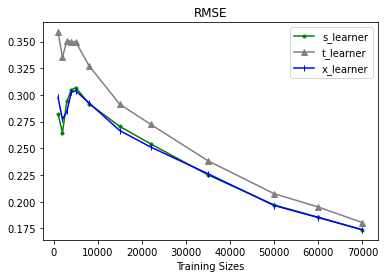

In [ ]:
fig1 = plt.gcf()
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['s_mse_eml_rf']), "green", label="s_learner", marker='.')
plt.plot(df_gotv['sample_sizes'] ,np.sqrt(df_gotv['t_mse_eml_rf']), "grey",  label="t_learner", marker='^')
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['x_mse_eml_rf']), "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("RMSE")
plt.xlabel('Training Sizes')
plt.show()
fig1.savefig("GOTV_RF_RMSE_python.png")

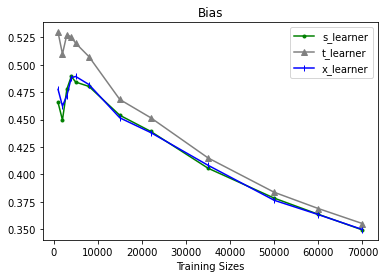

In [ ]:
fig1 = plt.gcf()
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['s_bias_eml_rf']), "green", label="s_learner", marker='.')
plt.plot(df_gotv['sample_sizes'] ,np.sqrt(df_gotv['t_bias_eml_rf']), "grey",  label="t_learner", marker='^')
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['x_bias_eml_rf']), "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("Bias")
plt.xlabel('Training Sizes')
plt.show()
fig1.savefig("GOTV_RF_Bias_python.png")

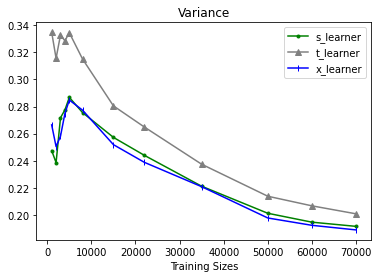

In [ ]:
fig1 = plt.gcf()
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['s_var_eml_rf']), "green", label="s_learner", marker='.')
plt.plot(df_gotv['sample_sizes'] ,np.sqrt(df_gotv['t_var_eml_rf']), "grey",  label="t_learner", marker='^')
plt.plot(df_gotv['sample_sizes'], np.sqrt(df_gotv['x_var_eml_rf']), "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("Variance")
plt.xlabel('Training Sizes')
plt.show()
fig1.savefig("GOTV_RF_Variance_python.png")